# Derivazioni ed alberi di parsing

Mi raccomando, aggiornate `liblet` (alla versione `1.1.0-alpha`), ad esempio con `pip install --upgrade liblet`; osservate che dalla penultima versione è stata aggiornata anche la dipendenza da ANTLR, dovrete probabilmente quindi usare di nuovo il comando `install_antlrjar` e aggiornare la confugirazione del vostro ambiente perché punti a `antlr-4.8-complete.jar`.

In [ ]:
from liblet import __version__, Tree, Grammar, Derivation, ProductionGraph, side_by_side

__version__

'1.1.0-alpha'

## Derivazioni e alberi di parsing

In [ ]:
# una grammatica banale per il linguaggio {'ab'}

G_ab = Grammar.from_string("""
S -> A B
A -> a
B -> b
""")
G_ab

Grammar(N={A, B, S}, T={a, b}, P=(S -> A B, A -> a, B -> b), S=S)

In [ ]:
# due possibili derivazioni

ab_0 = Derivation(G_ab).step([
    (0, 0), (2, 1), (1, 0)
])
ab_1 = Derivation(G_ab).step([
    (0, 0), (1, 0), (2, 1)
]) 

ab_0, ab_1

(S -> A B -> A b -> a b, S -> A B -> a B -> a b)

In [ ]:
# ma a ben guardare lo stesso albero…

side_by_side(
    ProductionGraph(ab_0),
    ProductionGraph(ab_1),
)    

## Dalla derivazione all'albero di parsing

La seguente procedura memorizza in `sentence` la forma sentenziale a cui è giuta la derivazione (di passo in passo) come una tupla di alberi annotati (rappresentati come una *lol*). 

Ciascun nodo dell'albero ha due etichette: `Symbol` che si riferisce ad uno dei simboli della grammatica e `nprord` pari ad un numero di produzione. I figli di ciascun nodo hanno i simboli contenuti nel lato destro della produzione di numero `nprord`.

Gli alberi vengono "completati" man mano che la procedura elabora i passi della derivazione; al termine le foglie degli alberi saranno simboli terminali (e `nprord` sarà convenzionalmente definito come `None`).

In [ ]:
def derivation_to_parsetree(d):
    # questa variabile si riferià all'albero di derivazione di d
    root = [{'Symbol': d.G.S, 'nprod': None}]
    # all'inizio la forma sentenziale è data dal simbolo distinto
    sentence = [root, ] 
    for prod, pos in d.steps():
        # l'albero corrente è deciso dalla posizione 
        # in cui è applicata la produzione
        tree = sentence[pos]
        # i figli sono dati dal lato destro d.G.P[prod].rhs
        children = [[{'Symbol': X, 'nprod': None}] for X in d.G.P[prod].rhs]
        # si aggiorna il valore di nprod e si aggiungono i figli all'albero
        tree[0]['nprod'] = prod
        tree.extend(children)
        sentence = sentence[:pos] + children + sentence[pos + 1:]
    return root

In [ ]:
pt_0 = derivation_to_parsetree(ab_0)
pt_0

[{'Symbol': 'S', 'nprod': 0},
 [{'Symbol': 'A', 'nprod': 1}, [{'Symbol': 'a', 'nprod': None}]],
 [{'Symbol': 'B', 'nprod': 2}, [{'Symbol': 'b', 'nprod': None}]]]

In [ ]:
# l'albero di parsing prodotto da liblet, e da derivation_to_parsetree

side_by_side(
    ProductionGraph(ab_0),
    Tree.from_lol(pt_0)
)

### <span style="color: red;">Per casa:</span> dall'albero alle derivazioni left/right-most

Le derivazioni leftmost e rightmost si possono ottenere, rispettivamente, tramite una visita in preordine e postordine dell'albero di parsing.

In [ ]:
def leftmost_from_parsetree(tree):
    result = []
    def visit(node):
        root, *children = node
        nprod = root['nprod']
        if nprod is not None: result.append(nprod)
        for child in children: visit(child)
    visit(tree)
    return result

In [ ]:
leftmost_from_parsetree(pt_0)

[0, 1, 2]

In [ ]:
def rightmost_from_parsetree(tree):
    result = []
    def visit(node):
        root, *children = node
        nprod = root['nprod']
        if nprod is not None: result.append(nprod)
        for child in reversed(children): visit(child)
    visit(tree)
    return result

In [ ]:
rightmost_from_parsetree(pt_0)

[0, 2, 1]

## Ambiguità

Pensiamo a grammatiche della forma `E -> E op E | n` dove `op` sia un operatore binario, definiamo una funzione ricorsiva che, dato un albero di parsing e il valore di `n`, valuti l'espressione aritmetica corrispondente.

In [ ]:
from operator import add, sub

DT = {
    '+': add,
    '-': sub
}

def eval_tree(tree, n):
    root, *children = tree
    if root['Symbol'] == 'n': return n
    if root['Symbol'] == 'E' and len(children) == 3:
        left, op, right = children
        return DT[op[0]['Symbol']](eval_tree(left, n), eval_tree(right, n))
    else: return eval_tree(children[0], n)

### Il caso "spurio"

In [ ]:
G_as = Grammar.from_string('E -> E + E | n')

# due derivazioni di n + n + n

as_0 = Derivation(G_as).leftmost([
    0, 1, 0, 1, 1
])
as_1 = Derivation(G_as).leftmost([
    0, 0, 1, 1, 1
])

side_by_side(
    ProductionGraph(as_0),
    ProductionGraph(as_1)
)

In [ ]:
# 1 + 1 + 1, comunque parsato, vale 3

(eval_tree(derivation_to_parsetree(as_0), 1),
 eval_tree(derivation_to_parsetree(as_1), 1))

(3, 3)

### Il caso "essenziale"

In [ ]:
G_ae = Grammar.from_string('E -> E - E | n')

# due derivazioni di n - n - n

ae_0 = Derivation(G_ae).leftmost([
    0, 1, 0, 1, 1
])
ae_1 = Derivation(G_ae).leftmost([
    0, 0, 1, 1, 1
])

side_by_side(
    ProductionGraph(ae_0),
    ProductionGraph(ae_1)
)

In [ ]:
# 1 - (1 - 1) e (1 - 1) - 1 hanno valori diversi!

(eval_tree(derivation_to_parsetree(ae_0), 1),
 eval_tree(derivation_to_parsetree(ae_1), 1))

(1, -1)

## <span style="color: red;">Esercizio per casa</span>: le ϵ-produzioni

In alcuni casi sono comode produzioni della forma $A\to \epsilon$ (chiamate ϵ-produzioni). Nella costruzione dell'albero dalla derivazione richiedono però un po' di attenzione…

Consideriamo ad esempio il caso del [linguaggio di Dyck](https://en.wikipedia.org/wiki/Dyck_language)

In [ ]:
G_dyck = Grammar.from_string('S -> S S | ( S ) | ε')

In [ ]:
# una derivazione leftmost di '(())'

dyck = 0, 1, 1, 2, 2

deriv = Derivation(G_dyck).leftmost(dyck)
deriv

S -> S S -> ( S ) S -> ( ( S ) ) S -> ( ( ) ) S -> ( ( ) )

In [ ]:
# la parola 
''.join(deriv.sentential_form())

'(())'

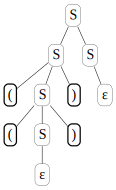

In [ ]:
# l'albero 

ProductionGraph(deriv)

Applicando la funzione `derivation_to_parsetree` si nota però un errore: sembra che da `)` derivi ϵ!

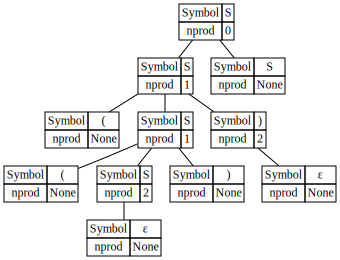

In [ ]:
Tree.from_lol(derivation_to_parsetree(deriv)) 